In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Tatacoffee13_21.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# VAR - Vector AutoRegression
VAR is used when there are variables which have an effect on each other. In case of restaurant visitors where the exogenous variable $holidays$ affected the $visitors$, it wasn't vice versa. However, there are many cases in which two variables have an effect on each other. Example is Personal Disposable Income affects the Spending and the amount of Spending is affected by the available Personal Disposable income in the hands of the people. The dataset here contains the income in the hands of the people and another dataset contains the spending. 

## Imports and Load the dataset

In [4]:
import numpy as np
import pandas as pd

# visualization import
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('Tatacoffee13_21.csv',index_col=0, parse_dates=True)


sp = pd.read_csv('Tatacoffee13_21.csv',index_col=0, parse_dates=True)



## Inspect the data

In [5]:
df.head()

,Open,High,Low,Close
Date,,,,
2013-01-01,1410.60,1427.90,1408.30,1415.10
2013-01-02,1421.00,1626.60,1416.15,1607.40
2013-01-03,1632.55,1673.90,1613.05,1626.20
2013-01-04,1627.75,1627.75,1574.60,1579.05
2013-01-07,1580.00,1639.50,1565.50,1595.65


In [6]:
sp.head()

,Open,High,Low,Close
Date,,,,
2013-01-01,1410.60,1427.90,1408.30,1415.10
2013-01-02,1421.00,1626.60,1416.15,1607.40
2013-01-03,1632.55,1673.90,1613.05,1626.20
2013-01-04,1627.75,1627.75,1574.60,1579.05
2013-01-07,1580.00,1639.50,1565.50,1595.65


Spending is correlated with the money in hand and vice versa. We need to join these two dataframes into one for our model. The datetime index is the same and that makes the joining task easy. 

In [8]:
df = df
df.head()

,Open,High,Low,Close
Date,,,,
2013-01-01,1410.60,1427.90,1408.30,1415.10
2013-01-02,1421.00,1626.60,1416.15,1607.40
2013-01-03,1632.55,1673.90,1613.05,1626.20
2013-01-04,1627.75,1627.75,1574.60,1579.05
2013-01-07,1580.00,1639.50,1565.50,1595.65


In [9]:
# check for null or missing values
df.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

Cool, so we do not have any null values in the dataset.

In [10]:
# the number of instances
len(df)

2225

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2225 entries, 2013-01-01 to 2021-12-28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2225 non-null   float64
 1   High    2225 non-null   float64
 2   Low     2225 non-null   float64
 3   Close   2225 non-null   float64
dtypes: float64(4)
memory usage: 166.9 KB


The datatype of the two features is also fine. All hygiene checks done. we will test for stationarity using the augmented dikcey fuller test.

## Plot the source data

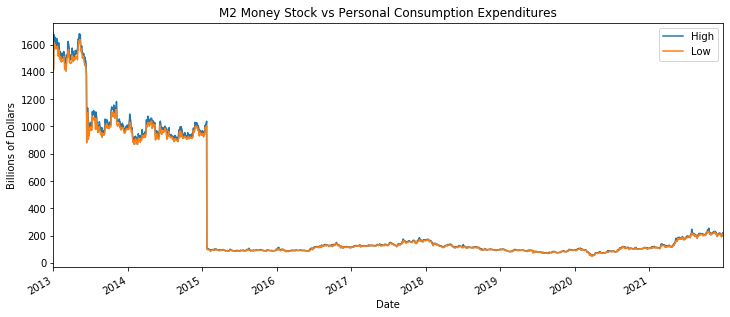

In [16]:
title = 'M2 Money Stock vs Personal Consumption Expenditures'
ylabel = 'Billions of Dollars'
xlabel='' #xlabel is not required. The datetime indes will be taken as the points on the x axis

ax = df['High'].plot(legend=True,title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel)
df['Low'].plot(legend=True);

In [14]:
def dickey_fuller(series,title='Your Dataset'):
    '''Hypothesis Test for stationarity '''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')
    
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')
        
    
    
    

In [18]:
dickey_fuller(df['High'],title='High')

Augmented Dickey Fuller Test for the dataset High
ADF test statistics       -2.462481
p-value                    0.124872
#lags                      0.000000
#observations           2224.000000
critical value (1%)       -3.433294
critical value (5%)       -2.862840
critical value (10%)      -2.567462
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [19]:
dickey_fuller(df['Low'],title='Low')

Augmented Dickey Fuller Test for the dataset Low
ADF test statistics       -3.055296
p-value                    0.030043
#lags                      2.000000
#observations           2222.000000
critical value (1%)       -3.433296
critical value (5%)       -2.862842
critical value (10%)      -2.567463
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


So both the Money and the Spending is non stationary. We will take the first order difference of the entire dataframe and re-run the dickey fuller test and store it in a separate dataframe so that the original dataframe is retained. 

In [20]:
df_diff = df.diff() # by default, diff performs the first order difference

In [21]:
df_diff.head()

,Open,High,Low,Close
Date,,,,
2013-01-01,NaN,NaN,NaN,NaN
2013-01-02,10.40,198.70,7.85,192.30
2013-01-03,211.55,47.30,196.90,18.80
2013-01-04,-4.80,-46.15,-38.45,-47.15
2013-01-07,-47.75,11.75,-9.10,16.60


There is NaN introduced due to the first order difference. So lets drop this missing value row.

In [24]:
df_diff = df_diff.dropna()

In [25]:
dickey_fuller(df_diff['High'],title='Low')

Augmented Dickey Fuller Test for the dataset Low
ADF test statistics      -47.493742
p-value                    0.000000
#lags                      0.000000
#observations           2223.000000
critical value (1%)       -3.433295
critical value (5%)       -2.862841
critical value (10%)      -2.567463
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [26]:
dickey_fuller(df_diff['Open'],title='Close')

Augmented Dickey Fuller Test for the dataset Close
ADF test statistics      -49.233920
p-value                    0.000000
#lags                      0.000000
#observations           2223.000000
critical value (1%)       -3.433295
critical value (5%)       -2.862841
critical value (10%)      -2.567463
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Money feature is still not stationary while Spending is stationary after the first order difference. I will take the second order difference of both the series so that they retain the same shape. Rerun the dickey fuller test for stationarity.

In [27]:
df_diff = df_diff.diff().dropna()
dickey_fuller(df_diff['Open'],title='Date')

Augmented Dickey Fuller Test for the dataset Date
ADF test statistics    -1.511403e+01
p-value                 7.624128e-28
#lags                   2.700000e+01
#observations           2.195000e+03
critical value (1%)    -3.433333e+00
critical value (5%)    -2.862858e+00
critical value (10%)   -2.567471e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [28]:
dickey_fuller(df_diff['Close'],title='Date')

Augmented Dickey Fuller Test for the dataset Date
ADF test statistics    -1.519609e+01
p-value                 5.917871e-28
#lags                   2.700000e+01
#observations           2.195000e+03
critical value (1%)    -3.433333e+00
critical value (5%)    -2.862858e+00
critical value (10%)   -2.567471e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Now, both the correlated features - Money and Spending are stationary. Hence we are good to go with the remaining steps of training, test predictions and finally forecasting into the future.

In [29]:
df_diff.head()

,Open,High,Low,Close
Date,,,,
2013-01-03,201.15,-151.40,189.05,-173.50
2013-01-04,-216.35,-93.45,-235.35,-65.95
2013-01-07,-42.95,57.90,29.35,63.75
2013-01-08,67.75,4.75,36.40,12.95
2013-01-09,13.10,-36.80,-24.55,-51.80


In [30]:
# check the length of the transformed df -- > should be 2 rows lesser than the original
len(df_diff)

2223

## Train Test Split


In [31]:
nobs = 12
train = df_diff[:-nobs]
test = df_diff[-nobs:]

In [32]:
len(train), len(test)

(2211, 12)

## VAR Model Order Selection 
VAR(p) of order p

So far in my other notebooks on time series on ARIMA and SARIMA, I used the auto_arima from pmdarima library. That method won't work here to determine the order of the VAR model. I will test this manually with a list of order p values and select the p value which returns the minimum AIC or BIC metric. Check Akaike Information Criterion and Bayesian Information Criterion for more details.

In [33]:
p = [1,2,3,4,5,6,7]  # try with list of 7 p values

for i in p:
    model = VAR(train)
    results = model.fit(i)
    print(f'VAR Order {i}')
    print('AIC {}'.format(results.aic))
    print('BIC {}'.format(results.bic))
    print()

VAR Order 1
AIC 20.987776708902377
BIC 21.039367186680764

VAR Order 2
AIC 19.967351222319028
BIC 20.060248744873633

VAR Order 3
AIC 19.4310142265207
BIC 19.56524964553548

VAR Order 4
AIC 19.088152734764158
BIC 19.263756939397354

VAR Order 5
AIC 18.737559143047356
BIC 18.954563059994015

VAR Order 6
AIC 18.44705720588393
BIC 18.70549179943862

VAR Order 7
AIC 18.306654877365727
BIC 18.606551149485348



Order 5 has the least AIC value. Lets select p = 5 in the modeling.

In [34]:
# lets confirm that both the variables are included in the model
model.endog_names

['Open', 'High', 'Low', 'Close']

## Fit the VAR(5) model

In [35]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Apr, 2022
Time:                     13:09:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.9546
Nobs:                     2206.00    HQIC:                   18.8168
Log likelihood:          -33104.2    FPE:                1.37284e+08
AIC:                      18.7376    Det(Omega_mle):     1.32178e+08
--------------------------------------------------------------------
Results for equation Open
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.036833         0.481875           -0.076           0.939
L1.Open         -1.312833         0.066743          -19.670           0.000
L1.High         -0.679604         0.076630           -8.869           0.000
L1.Lo

Check the correlation matrix printed at the last. 

## Predict the next 12 values
For predictions, VAR model uses .forecast() instead of predictions. This is similar to theHolt Winters. One of the requirement for VAR model is that we need to pass the lag order of the number of previous observations as well. Unfortunately, this lag order does not have the datetime index and hence we will have to build this ourselves.

In [36]:
lag_order = results.k_ar
lag_order

5

In [37]:
z = results.forecast(y=train.values[-lag_order:],steps = 12)
z

array([[ 3.47114325, -2.65613096,  0.75263997, -2.46849187],
       [-2.85974557,  0.25070745,  0.05703135,  1.76799221],
       [ 2.90907967,  1.33313823,  1.43761089,  0.28056018],
       [-0.85625082, -1.1130784 ,  0.07486385, -1.4678076 ],
       [-1.57157966, -0.1579786 , -2.41839957,  0.24697093],
       [ 1.2715297 ,  0.63119214,  0.7897666 ,  0.24408246],
       [-0.73330354, -0.81369887,  0.76978606,  0.03707164],
       [ 0.68782402,  0.85999621, -0.2192522 ,  0.25025081],
       [ 0.16319644, -0.22680125,  0.37308683, -0.19502234],
       [-0.67554684, -0.25013885, -0.82499037, -0.32116596],
       [-0.01104164, -0.02229836, -0.04095429,  0.22610667],
       [ 0.35874233,  0.22733801,  0.63763584,  0.16216582]])

In [38]:
test

,Open,High,Low,Close
Date,,,,
2021-12-13,5.75,-5.25,0.15,-5.45
2021-12-14,-8.80,-2.55,-2.45,0.10
2021-12-15,2.75,2.75,-0.20,-0.15
2021-12-16,-0.10,-0.10,-1.35,-1.45
2021-12-17,-4.10,-4.10,-0.95,-0.25
2021-12-20,-3.00,-3.00,-8.80,-6.15
2021-12-21,4.00,12.05,18.45,14.80
2021-12-22,10.90,-0.30,-0.35,0.25
2021-12-23,-3.80,-4.70,-4.65,-7.40


In [77]:
df[:5]

,Open,High,Low,Close
Date,,,,
2013-01-01,1634.35,1634.35,1408.30,1415.10
2013-01-02,3241.75,3241.75,1416.15,1607.40
2013-01-03,4867.95,4867.95,1613.05,1626.20
2013-01-04,6447.00,6447.00,1574.60,1579.05
2013-01-07,8042.65,8042.65,1565.50,1595.65


## Invert the Transformations

The forecasted values represent the 2nd order difference forecast. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

In [62]:
df['Open'] = (df['High'].iloc[-nobs-1] - df['Low'].iloc[-nobs-2]) + df['Close'].cumsum()


In [64]:
# Now build the forecast values from the first difference set
df['Open'] = df['Close'].iloc[-nobs-1] + df['High'].cumsum()

In [65]:
df

,Open,High,Low,Close
Date,,,,
2013-01-01,1644.35,1427.90,1408.30,1415.10
2013-01-02,3270.95,1626.60,1416.15,1607.40
2013-01-03,4944.85,1673.90,1613.05,1626.20
2013-01-04,6572.60,1627.75,1574.60,1579.05
2013-01-07,8212.10,1639.50,1565.50,1595.65
...,...,...,...,...
2021-12-22,769423.15,207.80,201.35,205.00
2021-12-23,769630.00,206.85,202.05,202.95
2021-12-24,769833.90,203.90,199.35,201.00


Similarly,lets do this for the spending column

In [66]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df['Open'] = (df['Open'].iloc[-nobs-1]-df['Open'].iloc[-nobs-2]) + df['Close'].cumsum()

# Now build the forecast values from the first difference set
df['High'] = df['High'].iloc[-nobs-1] + df['Close'].cumsum()

In [67]:
df

,Open,High,Low,Close
Date,,,,
2013-01-01,1634.35,1634.35,1408.30,1415.10
2013-01-02,3241.75,3241.75,1416.15,1607.40
2013-01-03,4867.95,4867.95,1613.05,1626.20
2013-01-04,6447.00,6447.00,1574.60,1579.05
2013-01-07,8042.65,8042.65,1565.50,1595.65
...,...,...,...,...
2021-12-22,755207.45,755207.45,201.35,205.00
2021-12-23,755410.40,755410.40,202.05,202.95
2021-12-24,755611.40,755611.40,199.35,201.00



## Plot the results

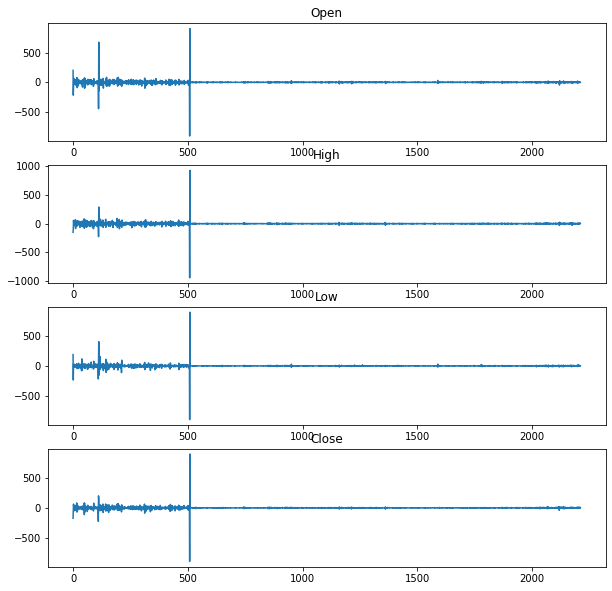

In [68]:
results.plot();

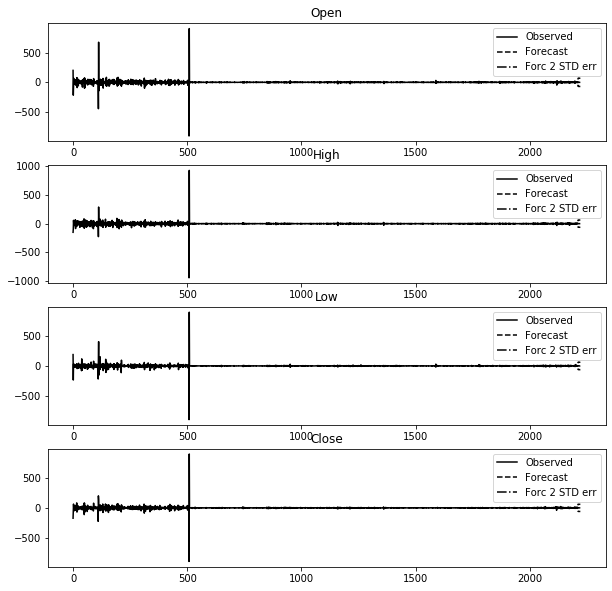

In [69]:
results.plot_forecast(12);

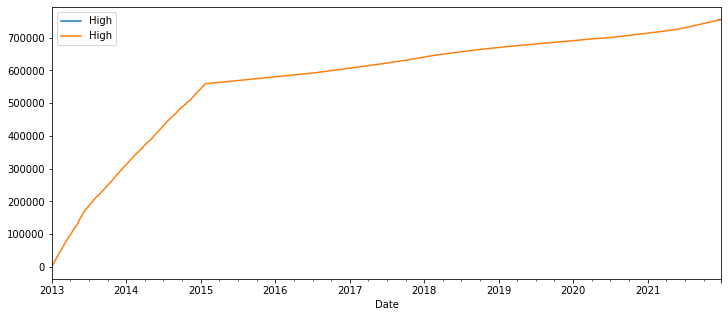

In [73]:
df['High'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df['High'].plot(legend=True);

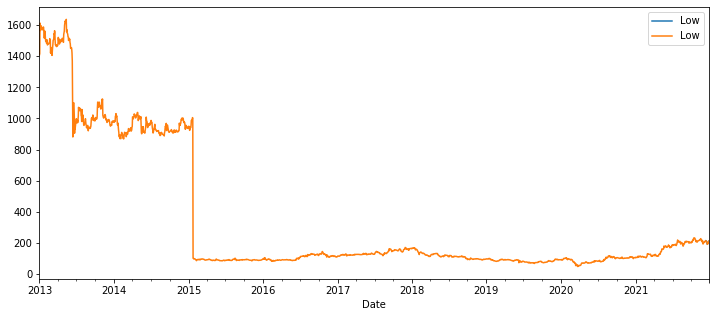

In [75]:
df['Low'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df['Low'].plot(legend=True);